# Redes Neuronales - Trabajo Practico N°2 - Rossman Store Sales

In [1]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

In [2]:
df = pd.read_feather('../processed_dataset/train_normalized_data.fth')
df_test = pd.read_feather('../processed_dataset/test_normalized_data.fth')

In [3]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
len(df_train)/len(df), len(df_val)/len(df), len(df), len(df_val)

(0.9642465458145908, 0.035753454185409164, 844338, 30188)

In [4]:
final_train = False

In [5]:
def get_metric(sales, sales_):
    return np.sqrt((((sales - sales_)/sales)**2).sum()/len(sales))


$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}$


In [6]:
max_sales = df_train['Sales'].max()
df.loc[:, 'Sales_norm'] = df['Sales'].values/max_sales

In [7]:
df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales

C:\Users\phili\AppData\Local\Temp\ipykernel_12852\2193462401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
C:\Users\phili\AppData\Local\Temp\ipykernel_12852\2193462401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales


In [8]:
print('Train:')
print(get_metric(df_train['Sales_norm'], 
                 df_train['Sales_norm'].mean()))
print('Val:')
get_metric(df_val['Sales_norm'], 
           df_train['Sales_norm'].mean())

Train:
0.6371089378658743
Val:


0.5496723521813329

In [9]:
def get_mean_by_column(column, sales_str):
    group_means_dict = {}
    group_mean_list = []
    for col_value, group_df in df_train.groupby(column):
        group_mean =  group_df[group_df[sales_str] > 0][sales_str].mean()
        group_means_dict[col_value] = group_mean
        group_mean_list.append(group_mean)
    print('Train:', get_metric(df_train[sales_str], 
                               df_train[column].apply(group_means_dict.get)))
    print('Val:', get_metric(df_val[sales_str], 
                             df_val[column].apply(group_means_dict.get)))
    return group_means_dict, group_mean_list

In [10]:
# Media por store
_ = get_mean_by_column('Store', 'Sales_norm')

Train: 0.3960913521241833
Val: 0.3071746085338872


In [11]:
# Media por dia de la semana
_ = get_mean_by_column('DayOfWeek', 'Sales_norm')

Train: 0.6008874922754364
Val: 0.5061392186635405


In [12]:
# Media por numera de semana (1-52)
_ = get_mean_by_column('Week', 'Sales_norm')

Train: 0.6077405789213655
Val: 0.5171468581189804


In [13]:
_ = get_mean_by_column('Month', 'Sales_norm')

Train: 0.6326710739722268
Val: 0.544465040070309


In [14]:
_ = get_mean_by_column('StateHoliday', 'Sales_norm')

Train: 0.6379671046048598
Val: 0.5494193814701794


In [15]:
_ = get_mean_by_column('SchoolHoliday', 'Sales_norm')

Train: 0.6352131730794401
Val: 0.5522886254888293


In [16]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [17]:
def get_keras_LR(X_columns, hidden_units=1):
    inputs = []
    activation = 'linear'
    if hidden_units>1:
        activation = 'relu'
    for i, col in enumerate(X_columns):
        inp = Input(shape=(X_train[i].shape[1],), name=f"{col}_input")
        inputs.append(inp)
    if len(X_columns)>1:
        concat_out = Concatenate()(inputs)
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(inputs[0])
    if hidden_units>1:
        dense_out = Dense(1, name='Dense_out')(dense_out)
    model = Model(inputs, dense_out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model


def get_embedings_NN(X_columns, hidden_units = 20, activation = 'relu'):
    embed_outs = []
    inputs = []
    for i, col in enumerate(X_columns):
        inp = Input(shape=(1,), name=f"{col}_input")
        inputs.append(inp)
        if col in embed_outs_dict:
            embed_out = Embedding(len(np.unique(X_train[i])), embed_outs_dict[col], name=f"{col}_embedding", mask_zero=False)(inp)
            out = Flatten(name=f"{col}_flatten")(embed_out)
            embed_outs.append(out)
        else:
            embed_outs.append(inp)
        
    if len(X_columns)>1:
        concat_out = Concatenate()(embed_outs)
        dense_out = Dense(hidden_units, activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, activation=activation)(out)
    out = Dense(1)(dense_out)
    model = Model(inputs, out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model

In [18]:
with_embed = True

embed_outs_dict = {'Store': 2, 'DayOfWeek': 2} #,  'Week': 2, 'Month': 2}
X_columns = list(embed_outs_dict.keys())# + ['BeforeStateHoliday_bool', 'Max_TemperatureC'] # ['Precipitationmm']

if final_train:
    X_train = np.hsplit(df[X_columns].values, len(X_columns))
    y_train = df['Sales_norm']
else:
    X_train = np.hsplit(df_train[X_columns].values, len(X_columns))
    y_train = df_train['Sales_norm']
    
X_val = np.hsplit(df_val[X_columns].values, len(X_columns))
X_test = np.hsplit(df_test[X_columns].values, len(X_columns))

if not with_embed:
    for i in range(len(X_train)):
        X_train[i] = to_categorical(X_train[i])
        X_val[i] = to_categorical(X_val[i])
        X_test[i] = to_categorical(X_test[i])

y_val = df_val['Sales_norm']

In [19]:
if with_embed:
    model = get_embedings_NN(X_columns)
else:
    model = get_keras_LR(X_columns, hidden_units=20)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Store_embedding (Embedding)    (None, 1, 2)         2230        ['Store_input[0][0]']            
                                                                                                  
 DayOfWeek_embedding (Embedding  (None, 1, 2)        14          ['DayOfWeek_input[0][0]']        
 )                                                                                            

c:\Users\phili\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
epochs = 5
model.compile(optimizers.Adam(lr=0.001), loss='mse', metrics=[rmspe, 'mse'])
cbs = [callbacks.ReduceLROnPlateau(monitor='val_rmspe', mode='min', verbose=1, patience=2), callbacks.ModelCheckpoint('../model_data/best_val_rmspe.hdf5', monitor='val_rmspe', mode='min', verbose=1, save_best_only=True)]
if final_train:
    model.fit(X_train, y_train, epochs=epochs, callbacks=cbs)
else:
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=cbs)

Epoch 1/5
25441/25443 [============================>.] - ETA: 0s - loss: 0.0020 - rmspe: 0.2883 - mse: 0.0020
Epoch 1: val_rmspe improved from inf to 0.21563, saving model to model_data\best_val_rmspe.hdf5
25443/25443 [==============================] - 36s 1ms/step - loss: 0.0020 - rmspe: 0.2883 - mse: 0.0020 - val_loss: 0.0014 - val_rmspe: 0.2156 - val_mse: 0.0014 - lr: 0.0010
Epoch 2/5
25432/25443 [============================>.] - ETA: 0s - loss: 0.0018 - rmspe: 0.2673 - mse: 0.0018
Epoch 2: val_rmspe improved from 0.21563 to 0.21229, saving model to model_data\best_val_rmspe.hdf5
25443/25443 [==============================] - 36s 1ms/step - loss: 0.0018 - rmspe: 0.2673 - mse: 0.0018 - val_loss: 0.0014 - val_rmspe: 0.2123 - val_mse: 0.0014 - lr: 0.0010
Epoch 3/5
25432/25443 [============================>.] - ETA: 0s - loss: 0.0018 - rmspe: 0.2655 - mse: 0.0018
Epoch 3: val_rmspe improved from 0.21229 to 0.20993, saving model to model_data\best_val_rmspe.hdf5
25443/25443 [===========

In [21]:
model.load_weights('../model_data/best_val_rmspe.hdf5')

In [22]:
model.evaluate(X_train, y_train)

25443/25443 [==============================] - 35s 1ms/step - loss: 0.0017 - rmspe: 0.2322 - mse: 0.0017


[0.0017099165124818683, 0.2321939766407013, 0.0017099165124818683]

In [23]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 0.0013 - rmspe: 0.2100 - mse: 0.0013


[0.001304813427850604, 0.2099555879831314, 0.001304813427850604]

In [24]:
from matplotlib import pyplot as plt

In [25]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


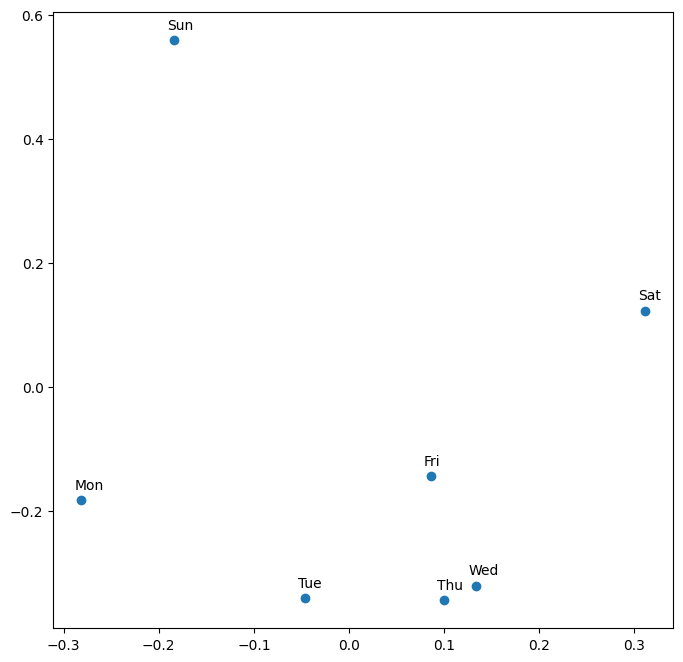

In [26]:
plot_embed('DayOfWeek_embedding', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(1115, 2)


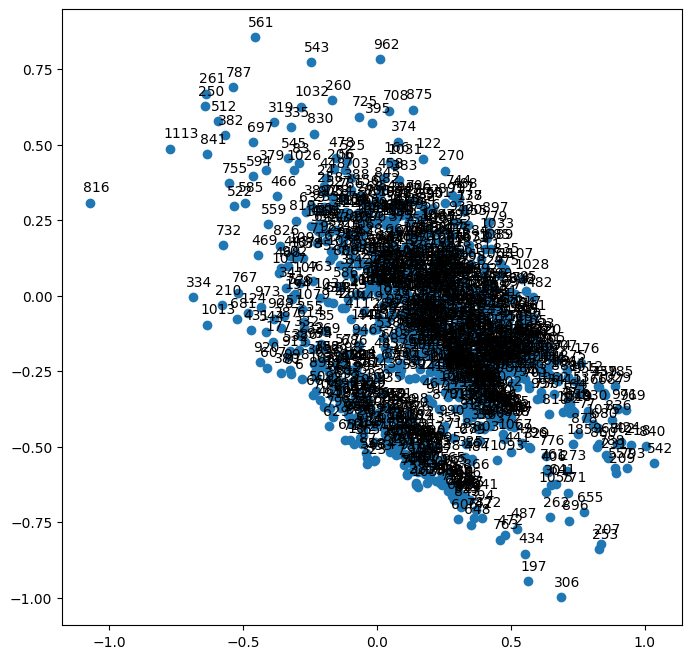

In [27]:
plot_embed('Store_embedding', list(range(1115)))

In [28]:
train_predictions = model.predict(X_train)*max_sales
get_metric(df_train['Sales'].values, train_predictions.reshape(-1))

25443/25443 [==============================] - 72s 3ms/step


0.3113181700441925

In [29]:
test_predictions = model.predict(X_test)*max_sales
test_predictions[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 4s 3ms/step


In [30]:
sample_csv = pd.read_csv('../dataset/sample_submission.csv')
sample_csv['Sales'] = test_predictions
sample_csv.head()

sample_csv.to_csv(f'../submision_data/submision_baseline_{"-".join(X_columns)}.csv', index=False)
